In [18]:
'''
import os
import numpy as np
from sys import platform
import os
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import os; from os import listdir; from os.path import isfile, join
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
from random import randrange
import pathlib
# Parallel computing
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
from timeit import default_timer as timer
# Importing rSNAPsim_IP
import rsnapsim as rss
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image
'''

'\nimport os\nimport numpy as np\nfrom sys import platform\nimport os\nfrom skimage import io ; from skimage.io import imread; from skimage.measure import find_contours\nfrom random import randrange\nimport os; from os import listdir; from os.path import isfile, join\nimport pandas as pd\nimport os; from os import listdir; from os.path import isfile, join\nimport re\nimport shutil\nfrom random import randrange\nimport pathlib\n# Parallel computing\nfrom joblib import Parallel, delayed\nimport multiprocessing\nnum_cores = multiprocessing.cpu_count()\nfrom timeit import default_timer as timer\n# Importing rSNAPsim_IP\nimport rsnapsim as rss\nimport ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image\n'

In [19]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays

import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
from skimage.exposure import rescale_intensity
import rsnapsim as rss
from skimage.measure import find_contours
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

# Parallel computing
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [20]:
print(np.__version__)

1.20.0


In [21]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = False

In [22]:
number_trajectories = 1000
simulation_time_in_sec = 1000
step_size_in_sec =1

In [23]:
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[2].joinpath('DataBases','gene_files')
#video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
#trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
#trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
#rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
#gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')

In [24]:
sequences_dir

PosixPath('/home/luisub/Desktop/rsnaped/DataBases/gene_files')

# Running SSA

In [25]:

gene_file_h2b = str(sequences_dir.joinpath('H2B_withTags.txt'))
gene_file_bact = str(sequences_dir.joinpath('Bactin_withTags.txt'))

print(gene_file_h2b)

/home/luisub/Desktop/rsnaped/DataBases/gene_files/H2B_withTags.txt


In [26]:
gene_file_h2b

'/home/luisub/Desktop/rsnaped/DataBases/gene_files/H2B_withTags.txt'

## Running the SSA in serial

In [27]:
#t = np.linspace(0,simulation_time_in_sec,simulation_time_in_sec+1)

In [28]:
def rsnapsim_ssa(gene_file,ke =3,ki=0.033,frames=100,n_traj=20):
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 1000
    t = np.linspace(0,t_burnin+frames,t_burnin+frames+1)
    ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=False,record_stats=False,n_traj=n_traj)
    ssa_int =  ssa_solution.intensity_vec[0,t_burnin:-1,:].T
    return ssa_int

In [29]:
start = timer()
ssa_solution_b_act = rsnapsim_ssa(gene_file_bact,frames=simulation_time_in_sec,n_traj=number_trajectories)
end = timer()
print('Time for serial ssa',round(end - start), ' sec')

Time for serial ssa 15  sec


In [30]:
ssa_solution_b_act.shape

(1000, 1000)

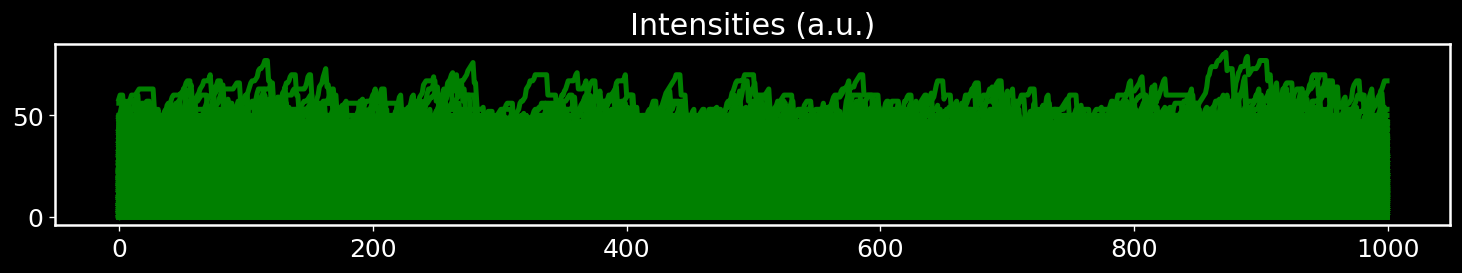

In [31]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_b_act.shape[0] ):
    plt.plot(ssa_solution_b_act[tr,:] , '-',linewidth = 3,color='green');
plt.title('Intensities (a.u.)')
plt.show()

## Running the SSA in parallel

In [32]:
def rsnapsim_ssa_parallel(gene_file,ke =3,ki=0.033,frames=100,n_traj=1):
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 10000
    t = np.linspace(0,t_burnin+frames,t_burnin+frames+1)
    ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=False,record_stats=False,n_traj=n_traj)
    ssa_int =  ssa_solution.intensity_vec[0,t_burnin:-1,:].T
    return ssa_int

In [33]:
start = timer()
list_ssa = Parallel(n_jobs=num_cores)(delayed(rsnapsim_ssa_parallel)(gene_file_bact,frames=simulation_time_in_sec) for i in range(0,number_trajectories)) 
ssa_solution_b_act_parallel = np.concatenate( list_ssa, axis=0 )
end = timer()
print('Time for parallel ssa',round(end - start), ' sec')

Time for parallel ssa 5  sec


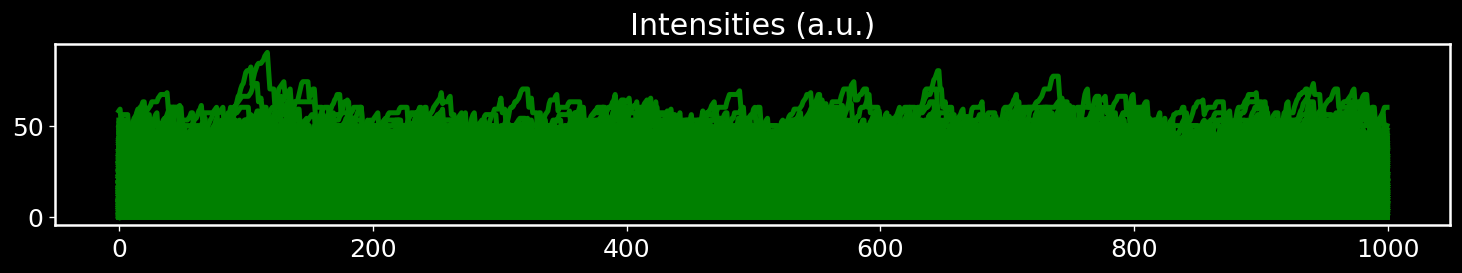

In [34]:
plt.figure(figsize=(15,2))
for tr in range(0,ssa_solution_b_act.shape[0] ):
    plt.plot(ssa_solution_b_act_parallel[tr,:] , '-',linewidth = 3,color='green');
plt.title('Intensities (a.u.)')
plt.show()